# 1. Set-up

## 1.1 Library

In [95]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import os 
import json

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# language detection
from langdetect import detect

# spacy for lemmatization
import spacy

# plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline
import bokeh

# text pre-processing 
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from cleantext import clean

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## 1.2 Read in data

### 1.2.1 Stakeholder Scraped Texts

#### 1.2.1.1 Stakeholder HTML Texts

In [ ]:
# first stakeholders html 
stakeholder_html_dir = "master_thesis_2025/stakeholder_data_extraction_pipeline/data/processed_data/html_text"

stakeholder_html_list = []
data_type = "stakeholder_html"
#languages_detected = []

for root, dirs, files in os.walk(stakeholder_html_dir):
    # check that files are detected
    file_count = sum(len(files) for _, _, files in os.walk(stakeholder_html_dir))
    print(f"Total files detected: {file_count}")

    for f in files:
        full_file_path = (os.path.join(root, f)) # save full file path
        
        # extract file_id, org_num, file_num using regex
        match = re.match(r"(\d+)_(\d+)\.json", f)
        if match:
            org_num, file_num = match.groups()
            file_id = f"{org_num}_{file_num}"
        else:
            print(f"Skipping {f}: Filename format not recognized")
            continue
        
        with open(full_file_path, "r", encoding="utf-8") as file:
            try:
                data = json.load(file)
                if "text" in data:
                    # extract text from json
                    text_content = data["text"]
                    
                    # detect language
                    lang = detect(text_content) 
                    #languages_detected.append(lang)
                    #print(lang)
                    
                    # FOR NOW ONLY EXTRACT ENGLISH TEXTS
                    if lang == 'en':
                        stakeholder_html_list.append({
                            "file_id": file_id,
                            "org": org_num,
                            "file_num": file_num,
                            "content": text_content, 
                            "data_type": data_type
                        })
                else: 
                    print(f'{full_file_path} no text')
            
            except json.JSONDecodeError as e:
                print(f"error {full_file_path}: {e}")

# convert the list to df
html_stakeholder = pd.DataFrame(stakeholder_html_list)
print(html_stakeholder.head())
print(html_stakeholder.tail())

Total files detected: 1487
    file_id  org file_num                                            content  \
0  102_1084  102     1084  Civil society organisations express concerns a...   
1  102_1088  102     1088  Societies and businesses face increasing uncer...   
2  102_1091  102     1091  EU’s ‘Fit for 55’ is unfit and unfair The Euro...   
3  102_1095  102     1095  WHEN: 12 December 2024 I TIME: 14:00 - 15:30 (...   
4  102_1096  102     1096  Climate and Energy WG meeting – 14 September –...   

          data_type  
0  stakeholder_html  
1  stakeholder_html  
2  stakeholder_html  
3  stakeholder_html  
4  stakeholder_html  
     file_id org file_num                                            content  \
1145   9_141   9      141  The past three years have been very crucial fo...   
1146   9_142   9      142  Minespider announces strategic partnership wit...   
1147   9_143   9      143  Executive Vice President and Chief Commercial ...   
1148   9_145   9      145  Aluminum MMI:

#### 1.2.1.2 PDF Texts

In [ ]:
# then read in stakeholders pdf
stakeholder_pdf_dir = "master_thesis_2025/stakeholder_data_extraction_pipeline/data/processed_data/pdf_text"

# keywords to skip (files containg these will be ignored)
skip_keywords = ['Concerns-Based Adoption Model']  # found overlap manually, also called CBAM

# list to store processed data
stakeholder_pdf_list = []
data_type = 'stakeholder_pdf'

# walk through json directory
for root, dirs, files in os.walk(stakeholder_pdf_dir):
    # check that files are detected
    file_count = sum(len(files) for _, _, files in os.walk(stakeholder_pdf_dir))
    print(f"Total files detected: {file_count}")

    for f in files:
            full_file_path = os.path.join(root, f)  # save full file path
            # extract file_id, org_num, file_num using regex
            match = re.match(r"(\d+)_(\d+)\.json", f)
            if match:
                org_num, file_num = match.groups()
                file_id = f"{org_num}_{file_num}"
            else:
                print(f"Skipping {f}: Filename format not recognized")
                continue
            
            with open(full_file_path, "r", encoding="utf-8") as file:
                try:
                    data = json.load(file)
                    
                    # ensure the necessary keys exist and process only English-language documents
                    if 'language' in data and 'pages' in data and data['language'] == 'Languages.ENGLISH':
                        full_text = " ".join(data['pages'].values())
                        
                        # Skip if any of the skip keywords are found in the text
                        if any(keyword.lower() in full_text.lower() for keyword in skip_keywords):
                            print(f"Skipping {f} due to keywords")
                            continue
                        
                        stakeholder_pdf_list.append({
                            "file_id": file_id,
                            "org": org_num,
                            "file_num": file_num,
                            "content": full_text, 
                            "data_type": data_type
                        })
                except json.JSONDecodeError as e:
                    print(f"error {f}: {e}")

# convert the list to df
pdf_stakeholder = pd.DataFrame(stakeholder_pdf_list)
print(pdf_stakeholder.head())
print(pdf_stakeholder.tail())

Total files detected: 481
Skipping 222_2149.json due to keywords
    file_id  org file_num                                            content  \
0  100_1060  100     1060  if\n8:\nS\n| ‘|\n! ry\nZ,\nY\nUp\ni\nA\nPo\n\\...   
1  101_1066  101     1066  Carbon Border Adjustments: Climate Protection ...   
2  101_1068  101     1068  Carbon\nMarket\nWatch\nA brief explanation of ...   
3  101_1072  101     1072  Carbon\nMarket\nWatch\nA brief explanation of ...   
4  101_1073  101     1073  O Carbon\nMarket\nWatch\nCarbon Market Watch’s...   

         data_type  
0  stakeholder_pdf  
1  stakeholder_pdf  
2  stakeholder_pdf  
3  stakeholder_pdf  
4  stakeholder_pdf  
     file_id org file_num                                            content  \
385   91_998  91      998  ©) MATERIALS\nBOLIDEN\nBoliden — Metals for\ng...   
386  92_1008  92     1008  A Close Brothers\nNOT FOR RELEASE, PUBLICATION...   
387  92_1015  92     1015  A Close Brothers\nNOT FOR RELEASE, PUBLICATION...   
388  92_

In [ ]:
# then EC have your say (feedback)
ec_hys_path = r"master_thesis_2025\eu_data_extraction\EC\have_your_say\data\combined_hys.json"

# list to store extracted data
ec_hys_list = []
data_type = "ec_hys"

# read JSON file
with open(ec_hys_path, "r", encoding="utf-8") as file:
    try:
        data = json.load(file)  # Load JSON file
        for entry in data:
            if "feedback" in entry:
                # combine 'feedback' and 'pdf_text' if they exist
                combined_text = " ".join(filter(None, [entry.get("feedback", ""), entry.get("pdf_text", "")]))

                ec_hys_list.append({
                    "file_id": entry.get("file_id"),  
                    "content": combined_text,
                    "data_type": data_type
                })
            else:
                print(f"{ec_hys_path} has no text")
    
    except json.JSONDecodeError as e:
        print(f"Error reading {ec_hys_path}: {e}")

# Convert list to DataFrame
ec_hys_df = pd.DataFrame(ec_hys_list)

print(ec_hys_df.head())
print(ec_hys_df.tail())

  file_id                                            content data_type
0  525305                                 See attached file.    ec_hys
1  525248                                               n.a.    ec_hys
2  525305                                 See attached file.    ec_hys
3  525248                                               n.a.    ec_hys
4  525246   AEGIS Europe is an industry alliance that bri...    ec_hys
     file_id                                            content data_type
398  3497854  Hello Dear Madam/Sir We are reaching you about...    ec_hys
399  3497758  The delivery of the information from the suppl...    ec_hys
400  3497706  The correct functioning of the CBAM Regulation...    ec_hys
401  3497693  Around chapter III, I believe the objective fo...    ec_hys
402  3497684  the register should promote sensible climate a...    ec_hys


## 1.3 Combine data

In [ ]:
all_docs = pd.concat([html_stakeholder,     # scraped stakeholders
                      pdf_stakeholder,      # scraped stakeholders 
                      ec_hys_df             # stakeholders feedback
                      ], ignore_index=True)
print(all_docs.head())

# Convert 'content' column to a list of Unicode strings
docs = all_docs["content"].astype(str).tolist()
print(f'number of documents: {len(docs)}')
#print(docs[0][:500])
#print(docs[:2])

    file_id  org file_num                                            content  \
0  102_1084  102     1084  Civil society organisations express concerns a...   
1  102_1088  102     1088  Societies and businesses face increasing uncer...   
2  102_1091  102     1091  EU’s ‘Fit for 55’ is unfit and unfair The Euro...   
3  102_1095  102     1095  WHEN: 12 December 2024 I TIME: 14:00 - 15:30 (...   
4  102_1096  102     1096  Climate and Energy WG meeting – 14 September –...   

          data_type  
0  stakeholder_html  
1  stakeholder_html  
2  stakeholder_html  
3  stakeholder_html  
4  stakeholder_html  
number of documents: 1943


# 2. Text pre-processing

steps inspired by https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

## 2.1 Define stopwords and regex patterns

In [102]:
from nltk.corpus import stopwords 

default_stopwords = set(stopwords.words("english"))  # start with English stopwords

custom_stopwords = {'http', 'https', 'www', 'pdf', 'mr', 'ms', 'mrs', 'press', 'release', 'please', 'consult', 'regulation'
                    'et', 'al', 'available', 'online', 'document', 'report', 'meeting', 'url', 'email', 'january', 
                    'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december',
                    'website', 'archive', 'ie', 'time', 'video', 'recording', 'jan', 'feb', 'mar', 'apr', 'may', 
                    'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', 'de', 'sgalg', 'organisation', 'org', 'page', 
                    'read', 'comment', 'position', 'paper', 'CEO', 'news'} # extend based on what has been found
extended_stopwords = default_stopwords.union(custom_stopwords)

In [103]:
def clean_ocr_noise(text):
    text = re.sub(r'-\s*\n\s*', '', text)          # Remove hyphenated line breaks
    text = re.sub(r'\n+', ' ', text)               # Replace newlines with space
    text = re.sub(r'\s{2,}', ' ', text)            # Reduce multiple spaces
    #text = re.sub(r'[•--]', '', text)           # Remove bullet-like characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)      # Remove non-ASCII chars (optional)
    return text

In [104]:
# Function to clean repeated character words
def clean_repeated_chars(text):
    text = re.sub(r'\b(\w)\1{2,}\b', '', text)  # Remove entire words with repeated chars (e.g., "aaa")
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text) # Limit repeated characters within words to 2 max (e.g., "soooon" -> "soon")
    text = re.sub(r'\s+', ' ', text).strip()    # Remove extra spaces
    return text

In [105]:
def remove_junk_tokens(doc):
    return [
        token for token in doc
        if len(token) > 2                          # remove very short tokens
        and not re.match(r'^[a-z]{1,2}$', token)   # remove tokens like "ae", "yy", etc.
        and not re.search(r'\d', token)            # remove tokens with numbers
        and token.isalpha()                        # keep only alphabetic tokens
    ]

In [106]:
def remove_hex_and_ids(doc):
    return [
        token for token in doc
        if not re.fullmatch(r'[a-f0-9]{8,}', token)   # long hex/hash strings
        and not re.fullmatch(r'\d{5,}', token)        # long numeric IDs
        and not re.fullmatch(r'[a-z]{1,2}_[a-z]{1,2}(_[a-z]{1,2})*', token)  # ee_ee_ee etc
    ]

## 2.2 Clean all_docs dataframe

In [107]:
import pandas as pd
import re
from cleantext import clean

def clean_text(text):
    # Convert to lowercase
    #text = text.lower()

    # Use clean() from cleantext to remove URLs, emails, phone numbers, etc.
    text = clean(
        text=text,
        fix_unicode=True,
        to_ascii=True,
        no_emails=True,
        no_urls=True,
        no_line_breaks=True,
        no_phone_numbers=True,
        no_punct=False,          # comment out if only running LDA
        lower=False,             # comment out if only running LDA (for QA model)
        #replace_with_punct="", # comment out if only running LDA (saving for QA model (retain punctuation))
        replace_with_url="", 
        replace_with_email=""
    )
    
    ########### COMMENT OUT IF RUNNING FOR LDA ############
    # Remove OCR noise and fix repeated characters
    #text = clean_ocr_noise(text)         # Ensure your clean_ocr_noise() function returns a string
    #text = clean_repeated_chars(text)    # This function should return a cleaned string
    #return text

    ####### COMMENT OUT IF RUNNING FOR QA MODEL ###
    text = clean_ocr_noise(text)         # Ensure your clean_ocr_noise() function returns a string
    text = clean_repeated_chars(text)    # This function should return a cleaned string
   
    # At this point, text is a string. 
    # Tokenize it into tokens using a regex to process further
    tokens = re.findall(r'\w+', text) 
    # Remove hex strings, IDs, and other junk tokens
    tokens = remove_hex_and_ids(tokens)  # Returns a list
    tokens = remove_junk_tokens(tokens)  # Returns a list

    # Optionally, join tokens back into a cleaned string
    return " ".join(tokens)

# Apply the cleaning function to the "content" column and store in a new column:
all_docs['cleaned_content'] = all_docs['content'].apply(clean_text)

# Optionally, inspect the cleaned content:
print(all_docs[['file_id', 'content', 'cleaned_content']].head())

    file_id                                            content  \
0  102_1084  Civil society organisations express concerns a...   
1  102_1088  Societies and businesses face increasing uncer...   
2  102_1091  EU’s ‘Fit for 55’ is unfit and unfair The Euro...   
3  102_1095  WHEN: 12 December 2024 I TIME: 14:00 - 15:30 (...   
4  102_1096  Climate and Energy WG meeting – 14 September –...   

                                     cleaned_content  
0  Civil society organisations express concerns a...  
1  Societies and businesses face increasing uncer...  
2  Fit for unfit and unfair The European Commissi...  
3  WHEN December TIME Bangkok Time Video Recordin...  
4  Climate and Energy meeting September Online th...  


In [ ]:
# save to excel 
#import openpyxl
#all_docs.to_excel("master_thesis_2025/RAW_stakeholder_comms.xlsx")

In [109]:
docs = all_docs["cleaned_content"].astype(str).tolist()
print(f'number of documents: {len(docs)}')

number of documents: 1943


## 2.3 Tokenize the documents

In [110]:
from nltk.tokenize import RegexpTokenizer

# Initialize the tokenizer; this one will extract alphanumeric tokens
tokenizer = RegexpTokenizer(r'\w+')

# Tokenize each cleaned document into a list of tokens
docs = [tokenizer.tokenize(doc) for doc in docs]

# Print the number of documents and a snippet of the first document's tokens
print(f'Number of documents: {len(docs)}')
print("Example tokens from first document:", docs[0][:20])

Number of documents: 1943
Example tokens from first document: ['Civil', 'society', 'organisations', 'express', 'concerns', 'about', 'the', 'agreement', 'reached', 'COREPER', 'Carbon', 'Border', 'Adjustment', 'Mechanism', 'CBAM', 'compromise', 'text', 'that', 'does', 'not']


## 2.3 Remove stopwords

In [111]:
docs = [[token for token in doc if token not in extended_stopwords] for doc in docs]

## 2.4 Lemmatize the documents

In [112]:
# Lemmatize the documents.
#from nltk.stem.wordnet import WordNetLemmatizer

#lemmatizer = WordNetLemmatizer()
#docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]

In [113]:
# testing with lemmatization that uses POS 
import spacy
nlp = spacy.load("en_core_web_sm")

def spacy_lemmatize_with_phrases(docs):
    lemmatized_docs = []
    for doc in docs:
        joined = " ".join(doc)
        parsed = nlp(joined)
        lemmatized = [
            token.lemma_ if '_' not in token.text else token.text  # preserve n-grams
            for token in parsed
            if not token.is_stop and not token.is_punct
        ]
        lemmatized_docs.append(lemmatized)
    return lemmatized_docs

docs = spacy_lemmatize_with_phrases(docs)

## 2.5 Remove junk tokens

In [114]:
docs = [remove_junk_tokens(doc) for doc in docs]

## 2.6 Bigram documents

In [115]:
from gensim.models.phrases import Phrases, Phraser

# Train bigram and trigram models
bigram_model = Phraser(Phrases(docs, min_count=10, threshold=10))
trigram_model = Phraser(Phrases(bigram_model[docs], min_count=5, threshold=15))

# Apply bigrams and trigrams to texts
docs = [trigram_model[bigram_model[doc]] for doc in docs]

## 2.7 Remove rare and common tokens

this code is taken directly from gensim docs: https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py

In [116]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)

# Filter out words that occur less than 50 documents, or more than 30% of the documents.
dictionary.filter_extremes(no_below=50, 
                           no_above=0.3)

## 2.8 Vectorization

In [117]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2423
Number of documents: 1943


# 3. LDA Model

## 3.1 Train model

### 3.1.1 Explore optimal topic number (obs: only run once)

In [52]:
#from gensim.models import LdaModel, CoherenceModel
#import matplotlib.pyplot as plt

#id2word = dictionary
#topic_range = list(range(5, 20, 2))  # Test from 5 to 20 topics
#coherence_scores = []

#for num in topic_range:
    # Train a new LDA model for each num_topics value
#    lda_model = LdaModel(
#        corpus=corpus, id2word=id2word, num_topics=num,
#        chunksize=2000, alpha=0.01, eta=0.01, passes=20, iterations=400,
#    per_word_topics=True, 
#    minimum_probability=0.0, 
#    random_state=42
#    )
    
    # Compute coherence score
#    coherence = CoherenceModel(model=lda_model, texts=docs, dictionary=id2word, coherence='c_v')
#    coherence_scores.append(coherence.get_coherence())

# Plot coherence scores
#plt.plot(topic_range, coherence_scores, marker='o')
#plt.xlabel("Number of Topics")
#plt.ylabel("Coherence Score")
#plt.title("Optimal Number of Topics")
#%matplotlib inline
#plt.show()

In [ ]:
# plotting optimized for thesis visualizations
from gensim.models import LdaModel, CoherenceModel
import matplotlib.pyplot as plt
import seaborn as sns

# Colorblind-friendly palette
color_palette = sns.color_palette("colorblind")

# Set seaborn style for academic paper
sns.set(style="whitegrid", context="paper", font_scale=1.3)
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=color_palette)

topic_range = list(range(2, 18, 2))
coherence_scores = []
id2word = dictionary

for num in topic_range:
    lda_model = LdaModel(
        corpus=corpus, id2word=id2word, num_topics=num,
        chunksize=2000, alpha='auto', eta='auto', passes=20, iterations=400, random_state = 42
    )
    coherence = CoherenceModel(model=lda_model, texts=docs, dictionary=id2word, coherence='c_v')
    coherence_scores.append(coherence.get_coherence())

# Plot
plt.figure(figsize=(8, 5))
plt.plot(topic_range, coherence_scores, marker='o', linestyle='-', linewidth=2, markersize=6)
plt.xlabel("Number of Topics")
plt.ylabel("Model Coherence Score (C_v)")
plt.title("Topic Coherence Analysis for Stakeholder Corpus")
plt.xticks(topic_range)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### 3.1.2 Training

In [129]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 15
chunksize = 2000
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
#temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary

lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every,
    per_word_topics=True, 
    minimum_probability=0.0, 
    random_state=42
)

## 3.2 Explore topics

In [130]:
top_topics = lda_model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -1.1219.
[([(0.009155441, 'carbon_price'),
   (0.007961076, 'electricity'),
   (0.007086306, 'domestic'),
   (0.006559385, 'carbon_leakage'),
   (0.0054740636, 'free_allocation'),
   (0.005105741, 'climate_policy'),
   (0.0047981795, 'carbon_pricing'),
   (0.004754061, 'proposal'),
   (0.004709736, 'importer'),
   (0.0044389153, 'scope'),
   (0.004302781, 'exist'),
   (0.004279528, 'benchmark'),
   (0.004096274, 'propose'),
   (0.0040586507, 'option'),
   (0.004045769, 'effect'),
   (0.004004823, 'different'),
   (0.0039769113, 'competitiveness'),
   (0.003916155, 'WTO'),
   (0.0037142562, 'objective'),
   (0.003695593, 'international')],
  -0.8212132076655971),
 ([(0.013919395, 'hydrogen'),
   (0.008371243, 'low_carbon'),
   (0.0078108916, 'project'),
   (0.0066969167, 'decarbonisation'),
   (0.006632339, 'demand'),
   (0.006163617, 'renewable'),
   (0.0061534666, 'green'),
   (0.005980403, 'infrastructure'),
   (0.005227906, 'transition'),
   (0.0052180355, '

In [131]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence 
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.138550605594991

Coherence Score:  0.4551490279211452


In [132]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'})
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.130634  0.052213       1        1  15.555175
10    -0.039557 -0.034054       2        1  10.311706
9      0.007655 -0.038475       3        1  10.289884
7      0.007220  0.155670       4        1   8.928190
5      0.056441  0.035859       5        1   7.578335
4     -0.047928  0.016766       6        1   6.956924
2      0.109119  0.004063       7        1   6.758131
14    -0.018186  0.091204       8        1   6.003507
11    -0.017334  0.001434       9        1   5.893996
3      0.139175 -0.000464      10        1   4.616283
12     0.066092 -0.027077      11        1   4.299007
0     -0.176399 -0.028139      12        1   4.144370
13     0.053028 -0.081375      13        1   3.242438
8      0.018180  0.042235      14        1   2.804395
1     -0.026872 -0.189860      15        1   2.617658, topic_info=                 Term         Freq        Total Category  logprob  loglift
664             steel  4589.000000  4589.000000  Default  30.0000  30.0000
342       electricity  3307.000000  3307.000000  Default  29.0000  29.0000
1367           cement  1911.000000  1911.000000  Default  28.0000  28.0000
970           revenue  2406.000000  2406.000000  Default  27.0000  27.0000
516         aluminium  1373.000000  1373.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
204          proposal    98.998100  2244.752410  Topic15  -5.4076   0.5216
1212         estimate    81.117393  1096.989877  Topic15  -5.6068   1.0385
14    decarbonisation    85.502321  1429.662129  Topic15  -5.5542   0.8262
374     international    87.016103  1933.484948  Topic15  -5.5366   0.5419
167        low_carbon    82.983610  1919.942008  Topic15  -5.5841   0.5015

[909 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1421      2  0.062988         Africa
1421      3  0.025195         Africa
1421      6  0.566891         Africa
1421      7  0.050390         Africa
1421      8  0.018896         Africa
...     ...       ...            ...
1022      8  0.013290  zero_emission
1022      9  0.048731  zero_emission
1022     11  0.013290  zero_emission
1022     13  0.146194  zero_emission
1022     14  0.039871  zero_emission

[7797 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 11, 10, 8, 6, 5, 3, 15, 12, 4, 13, 1, 14, 9, 2])

In [142]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

prepared_vis = gensimvis.prepare(lda_model, corpus, id2word)
print(prepared_vis.topic_coordinates)

              x         y  topics  cluster       Freq
topic                                                
6     -0.130634  0.052213       1        1  15.553812
10    -0.039557 -0.034054       2        1  10.312300
9      0.007655 -0.038475       3        1  10.289718
7      0.007220  0.155670       4        1   8.926200
5      0.056441  0.035859       5        1   7.579972
4     -0.047928  0.016766       6        1   6.957470
2      0.109119  0.004063       7        1   6.759367
14    -0.018186  0.091204       8        1   6.005187
11    -0.017334  0.001434       9        1   5.892823
3      0.139175 -0.000464      10        1   4.613781
12     0.066092 -0.027077      11        1   4.296696
0     -0.176399 -0.028139      12        1   4.146381
13     0.053028 -0.081375      13        1   3.244869
8      0.018180  0.042235      14        1   2.803498
1     -0.026872 -0.189860      15        1   2.617926


In [ ]:
for i in range(lda_model.num_topics):
    print(f"Topic {i}: {[word for word, _ in lda_model.show_topic(i, topn=10)]}")

topic_labels = {
    0: "Carbon Pricing",
    1: "Low-Carbon Cement",
    2: "Carbon \nAccounting",
    3: "Green \nFinance",  
    4: "International \nTrade",
    5: "Supply Chain \nSustainability",
    6: "Protection from \nCarbon \nLeakage", 
    7: "Sustainability \nReporting", 
    8: "Low-Carbon \nInfrastructure",
    9: "Low-Carbon \nTechnologies",
    10: "Green Steel",
    11: "Industrial \nDecarbonization", 
    12: "Circular Economy",
    13: "NOISE", 
    14: "Climate \nGovernance"
}

Topic 0: ['steel', 'aluminium', 'India', 'carbon_cost', 'tonne', 'China', 'total', 'steel_industry', 'source', 'million_tonne']
Topic 1: ['cement', 'cement_industry', 'Cement', 'Director', 'construction', 'concrete', 'Manager', 'project', 'climate_action', 'CCS']
Topic 2: ['sustainability', 'strategy', 'datum', 'sustainable', 'ESG', 'supply_chain', 'economic', 'opportunity', 'event', 'value']
Topic 3: ['government', 'tax', 'member', 'China', 'state', 'loan', 'Government', 'project', 'financial', 'International']
Topic 4: ['revenue', 'China', 'tax', 'resource', 'European_Union', 'budget', 'international', 'agreement', 'tariff', 'source']
Topic 5: ['project', 'activity', 'Group', 'plant', 'operation', 'supplier', 'customer', 'total', 'relate', 'performance']
Topic 6: ['carbon_price', 'electricity', 'domestic', 'carbon_leakage', 'free_allocation', 'climate_policy', 'carbon_pricing', 'proposal', 'importer', 'scope']
Topic 7: ['information', 'datum', 'requirement', 'report', 'Regulation', '

In [184]:
# ─── 1. PREP DATA ───────────────────────────────────────────────────────────────
# define df
df_coords = prepared_vis.topic_coordinates.reset_index()
df_coords = df_coords.rename(columns={'Freq': 'topic_size', 'topic': 'topic_id'})

# Filter out topic 13 (noise topic)
df_coords = df_coords[df_coords['topic_id'] != 13].copy()

# Map final topic labels
OG_topic_labels = {
    0: "Climate Governance",
    2: "Sustainability Reporting",
    3: "Green Finance",  
    4: "Low Carbon Infrastructure",
    5: "Protection from Carbon Leakage",
    6: "Low Carbon Cement",
    7: "Green Steel", 
    8: "Carbon Accounting", 
    9: "Low Carbon Technologies",
    10: "Circular Economy",
    11: "Carbon Pricing",
    12: "Industrial Decarbonization",
    13: "Supply Chain Sustainability",
    14: "International Trade"
}

topic_labels = {
    0: "Carbon Pricing",
    1: "Low-Carbon Cement",
    2: "Carbon \nAccounting",
    3: "Green \nFinance",  
    4: "International \nTrade",
    5: "Supply Chain \nSustainability",
    6: "Protection from \nCarbon \nLeakage", 
    7: "Sustainability \nReporting", 
    8: "Low-Carbon \nInfrastructure",
    9: "Low-Carbon \nTechnologies",
    10: "Green Steel",
    11: "Industrial \nDecarbonization", 
    12: "Circular Economy",
    13: "NOISE", 
    14: "Climate \nGovernance"
}

df_coords['label'] = df_coords['topic_id'].map(topic_labels)

# Scale bubble areas
size_scale = 6000
df_coords['scaled_size'] = (df_coords['topic_size'] / df_coords['topic_size'].max()) * size_scale


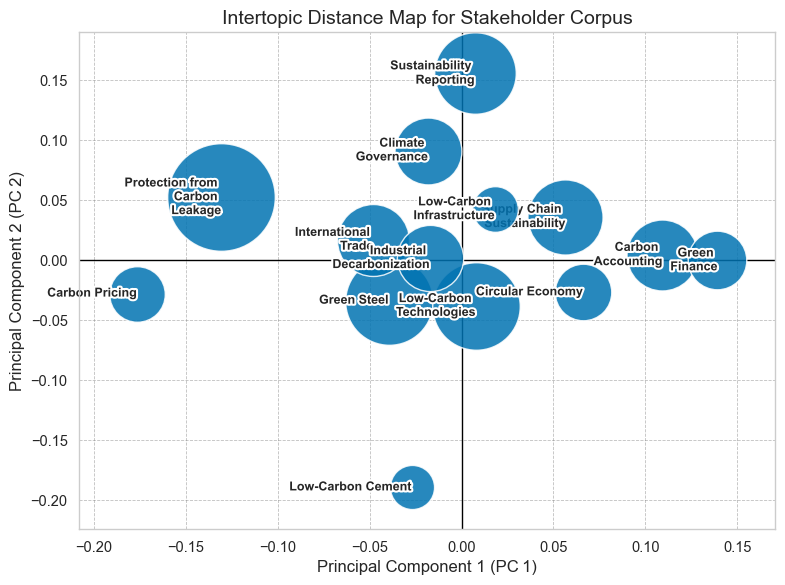

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patheffects import withStroke


# ─── 2. STYLING ─────────────────────────────────────────────────────────────────
sns.set(style="whitegrid", context="paper", font_scale=1.2)
palette = sns.color_palette("colorblind", df_coords['cluster'].nunique())

# Determine plot limits with a margin
x_min, x_max = df_coords['x'].min(), df_coords['x'].max()
y_min, y_max = df_coords['y'].min(), df_coords['y'].max()
x_margin = (x_max - x_min) * 0.1
y_margin = (y_max - y_min) * 0.1

# ─── 3. PLOT ────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))

# Background & quadrant lines

ax.grid(which='major', linestyle='--', linewidth=0.6, color='gray', alpha=0.5)
ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

# Scatter bubbles + center labels with halo effect
for _, row in df_coords.iterrows():
    c = palette[int(row['cluster']) - 1]
    ax.scatter(row['x'], row['y'],
               s=row['scaled_size'],
               color=c,
               edgecolors='white',
               linewidth=1,
               alpha=0.85,
               zorder=2)
    
    halo = withStroke(linewidth=3, foreground='white')
    ax.text(row['x'], row['y'],
            row['label'],
            ha='right', va='center',
            fontsize=9, weight='bold',
            path_effects=[halo],
            zorder=2)

# ─── 4. FINAL TOUCHES ───────────────────────────────────────────────────────────
ax.set_xlim(x_min - x_margin, x_max + x_margin)
ax.set_ylim(y_min - y_margin, y_max + y_margin)

ax.set_xlabel("Principal Component 1 (PC 1)", fontsize=12)
ax.set_ylabel("Principal Component 2 (PC 2)", fontsize=12)
ax.set_title("Intertopic Distance Map for Stakeholder Corpus", fontsize=14)

#ax.set_aspect('equal', 'box')

plt.tight_layout()
#plt.savefig("stakeholder_intertopic_map_final.png", dpi=300)
plt.show()

# 4. Combine Stakeholder and EU Corpus Topics

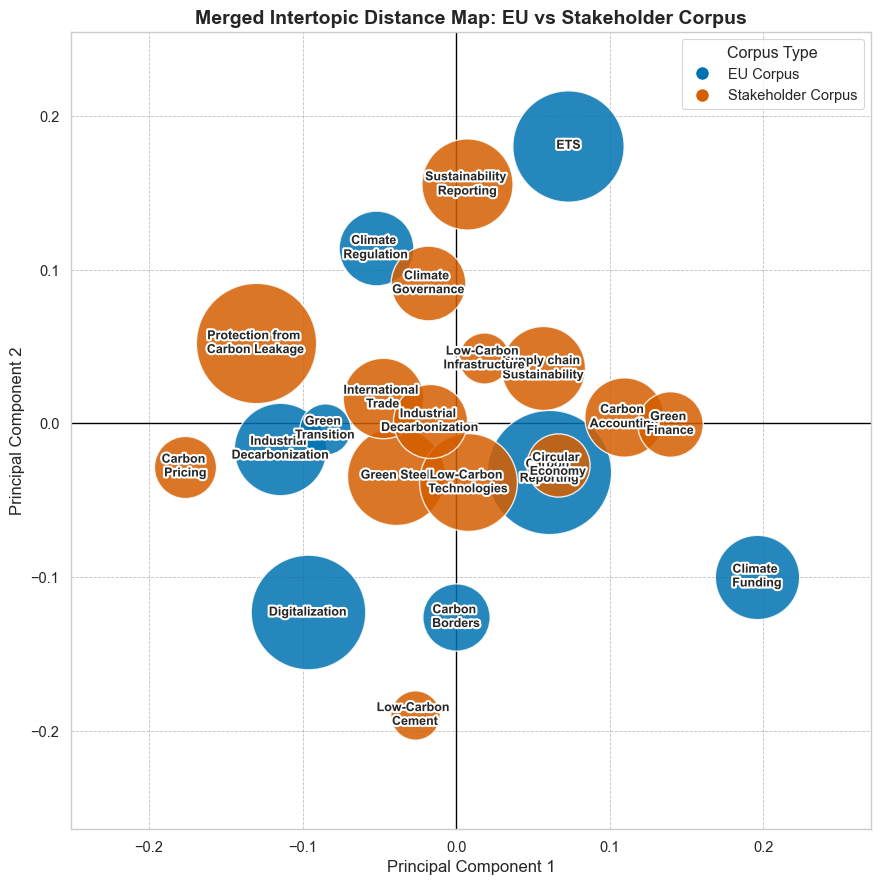

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patheffects import withStroke
import pandas as pd

# ─── 1. PREPARE EU CORPUS DATA ──────────────────────────────────────────────────
# Manually defining the EU corpus data from EU_lda_modelling
eu_data = {
    'x': [-0.093862, 0.060540, -0.096788, 0.072958, -0.114656, 0.195680, -0.052561, 0.114406, -0.000077, -0.085640],
    'y': [0.057344, -0.031419, -0.123051, 0.180739, -0.016511, -0.099756, 0.114078, 0.048146, -0.126141, -0.003429],
    'topic_id': [7, 1, 5, 6, 0, 8, 3, 4, 2, 9],  # Corrected IDs for EU topics
    'cluster': [1] * 10,
    'topic_size': [20.09, 16.59, 14.13, 13.33, 9.18, 7.64, 6.01, 5.33, 4.87, 2.82]
}

# Create the EU DataFrame
df_coords_eu = pd.DataFrame(eu_data)
df_coords_eu = df_coords_eu[(df_coords_eu['topic_id'] != 7) & (df_coords_eu['topic_id'] !=4)].copy()

# EU topic labels
eu_topic_labels = {
    0: "Industrial \nDecarbonization",
    1: "Carbon \nReporting",
    2: "Carbon \nBorders",
    3: "Climate \nRegulation",
    5: "Digitalization",
    6: "ETS",
    8: "Climate \nFunding",
    9: "Green \nTransition"
}
df_coords_eu['label'] = df_coords_eu['topic_id'].map(eu_topic_labels)
df_coords_eu['corpus'] = 'EU'

# ─── 2. PREPARE STAKEHOLDER CORPUS DATA (assuming existing DataFrame) ────────────
# Stakeholder topic labels
stakeholder_topic_labels = {
    0: "Carbon \nPricing",
    1: "Low-Carbon \nCement",
    2: "Carbon \nAccounting",
    3: "Green \nFinance",  
    4: "International \nTrade",
    5: "Supply chain \nSustainability",
    6: "Protection from \nCarbon Leakage", 
    7: "Sustainability \nReporting", 
    8: "Low-Carbon \nInfrastructure",
    9: "Low-Carbon \nTechnologies",
    10: "Green Steel",
    11: "Industrial \nDecarbonization", 
    12: "Circular \nEconomy",
    13: "NOISE", 
    14: "Climate \nGovernance"
}
df_coords_stakeholder = prepared_vis.topic_coordinates.reset_index()
df_coords_stakeholder = df_coords_stakeholder.rename(columns={'Freq': 'topic_size', 'topic': 'topic_id'})
df_coords_stakeholder = df_coords_stakeholder[df_coords_stakeholder['topic_id'] != 13].copy()
df_coords_stakeholder['label'] = df_coords_stakeholder['topic_id'].map(stakeholder_topic_labels)
df_coords_stakeholder['corpus'] = 'Stakeholder'

# ─── 3. COMBINE DATAFRAMES ──────────────────────────────────────────────────────
df_combined = pd.concat([df_coords_eu, df_coords_stakeholder], ignore_index=True)

# Scale bubble areas
size_scale = 8000
df_combined['scaled_size'] = (df_combined['topic_size'] / df_combined['topic_size'].max()) * size_scale

# ─── 4. STYLING ─────────────────────────────────────────────────────────────────
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Distinct colors: Blue for EU, Orange for Stakeholder
palette = {"EU": "#0072b2", "Stakeholder": "#D55E00"}

# Plot limits with margin
x_min, x_max = df_combined['x'].min(), df_combined['x'].max()
y_min, y_max = df_combined['y'].min(), df_combined['y'].max()
x_margin = (x_max - x_min) * 0.2
y_margin = (y_max - y_min) * 0.2

# ─── 5. PLOT ────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 9))

# Background & quadrant lines
ax.grid(which='major', linestyle='--', linewidth=0.6, color='gray', alpha=0.5)
ax.axhline(0, color='black', linewidth=1)
ax.axvline(0, color='black', linewidth=1)

# Scatter bubbles + center labels with halo effect
for _, row in df_combined.iterrows():
    c = palette[row['corpus']]
    ax.scatter(row['x'], row['y'],
               s=row['scaled_size'],
               color=c,
               edgecolors='white',
               linewidth=1,
               alpha=0.85,
               zorder=2)

    # Add text label with halo effect
    halo = withStroke(linewidth=3, foreground='white')
    ax.text(row['x'], row['y'],
            row['label'],
            ha='center', va='center',
            fontsize=9, weight='bold',
            path_effects=[halo],
            zorder=3)

# ─── 6. FINAL TOUCHES ───────────────────────────────────────────────────────────
ax.set_xlim(x_min - x_margin, x_max + x_margin)
ax.set_ylim(y_min - y_margin, y_max + y_margin)

ax.set_xlabel("Principal Component 1", fontsize=12)
ax.set_ylabel("Principal Component 2", fontsize=12)
ax.set_title("Merged Intertopic Distance Map: EU vs Stakeholder Corpus", fontsize=14, weight='bold')

# Add a legend to differentiate between EU and Stakeholder
handles = [plt.Line2D([0], [0], marker='o', color='w', label='EU Corpus', 
                      markerfacecolor=palette['EU'], markersize=10),
           plt.Line2D([0], [0], marker='o', color='w', label='Stakeholder Corpus', 
                      markerfacecolor=palette['Stakeholder'], markersize=10)]
ax.legend(handles=handles, title="Corpus Type", loc='upper right')

ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.show()

In [262]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patheffects import withStroke
import pandas as pd


def prepare_data(eu_data, stakeholder_data):
    """Prepares combined data from EU and Stakeholder corpora."""
    df_coords_eu = pd.DataFrame(eu_data)
    df_coords_stakeholder = pd.DataFrame(stakeholder_data)
    df_combined = pd.concat([df_coords_eu, df_coords_stakeholder], ignore_index=True)
    df_combined['scaled_size'] = (df_combined['topic_size'] / df_combined['topic_size'].max()) * 5000
    return df_combined

def plot_bubble_chart(df, toright_labels, down_labels, title):
    """Plots the bubble chart with dynamic font scaling and external labels."""
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.set(style="whitegrid", context="paper", font_scale=1.2)
    palette = {"EU": "#0072b2", "Stakeholder": "#D55E00"}

    for _, row in df.iterrows():
        c = palette[row['corpus']]
        ax.scatter(row['x'], row['y'],
                   s=row['scaled_size'],
                   color=c, edgecolors='white',
                   linewidth=1, alpha=0.85)

        font_size = max(8, min(12, row['scaled_size'] / 500))
        halo = withStroke(linewidth=3, foreground='white')

        if row['label'] in toright_labels:
            ax.text(row['x'] + 0.003, row['y'],  # Move slightly to the right
                    row['label'],
                    ha='center', va='center',
                    fontsize=font_size, weight='bold',
                    path_effects=[halo])
        elif row['label'] in down_labels:
            ax.text(row['x'], row['y'] - 0.033,  # Move slightly down
                    row['label'],
                    ha='center', va='center',
                    fontsize=font_size, weight='bold',
                    path_effects=[halo])

        else:
            ax.text(row['x'], row['y'], row['label'], ha='center', va='center',
                    fontsize=font_size, weight='bold', path_effects=[halo])

    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Principal Component 1", fontsize=12)
    ax.set_ylabel("Principal Component 2", fontsize=12)
    ax.grid(which='major', linestyle='--', linewidth=0.6, color='gray', alpha=0.85)
    ax.axhline(0, color='black', linewidth=1)
    ax.axvline(0, color='black', linewidth=1)
    plt.savefig("eu_and_stakeholder_intertopic_map_final.png", dpi=300)
    plt.show()

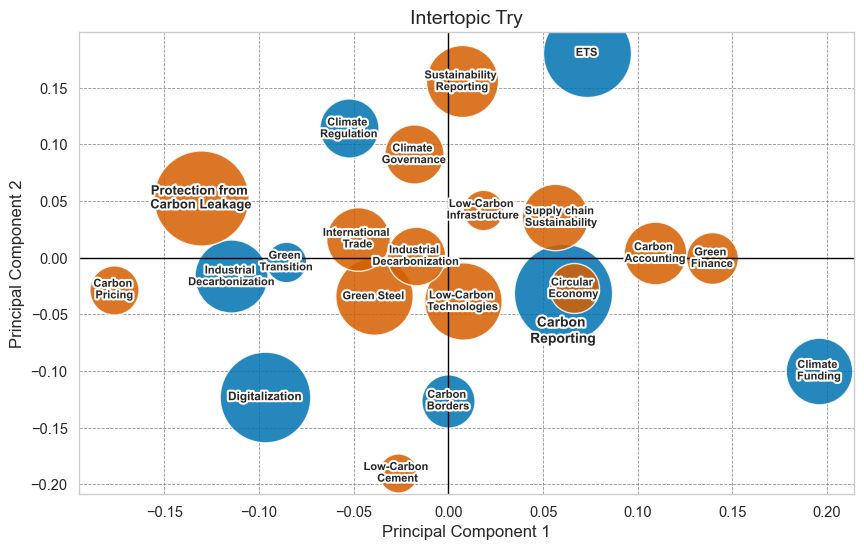

In [263]:
def main(): 
    # ─── 1. PREPARE EU CORPUS DATA ──────────────────────────────────────────────────
    # Manually defining the EU corpus data from EU_lda_modelling
    eu_data = {
        'x': [-0.093862, 0.060540, -0.096788, 0.072958, -0.114656, 0.195680, -0.052561, 0.114406, -0.000077, -0.085640],
        'y': [0.057344, -0.031419, -0.123051, 0.180739, -0.016511, -0.099756, 0.114078, 0.048146, -0.126141, -0.003429],
        'topic_id': [7, 1, 5, 6, 0, 8, 3, 4, 2, 9],  # Corrected IDs for EU topics
        'cluster': [1] * 10,
        'topic_size': [20.09, 16.59, 14.13, 13.33, 9.18, 7.64, 6.01, 5.33, 4.87, 2.82]
    }

    # Create the EU DataFrame
    df_coords_eu = pd.DataFrame(eu_data)
    df_coords_eu = df_coords_eu[(df_coords_eu['topic_id'] != 7) & (df_coords_eu['topic_id'] !=4)].copy()

    # EU topic labels
    eu_topic_labels = {
        0: "Industrial \nDecarbonization",
        1: "Carbon \nReporting",
        2: "Carbon \nBorders",
        3: "Climate \nRegulation",
        5: "Digitalization",
        6: "ETS",
        8: "Climate \nFunding",
        9: "Green \nTransition"
    }
    df_coords_eu['label'] = df_coords_eu['topic_id'].map(eu_topic_labels)
    df_coords_eu['corpus'] = 'EU'

    # ─── 2. PREPARE STAKEHOLDER CORPUS DATA (assuming existing DataFrame) ────────────
    # Stakeholder topic labels
    stakeholder_topic_labels = {
        0: "Carbon \nPricing",
        1: "Low-Carbon \nCement",
        2: "Carbon \nAccounting",
        3: "Green \nFinance",  
        4: "International \nTrade",
        5: "Supply chain \nSustainability",
        6: "Protection from \nCarbon Leakage", 
        7: "Sustainability \nReporting", 
        8: "Low-Carbon \nInfrastructure",
        9: "Low-Carbon \nTechnologies",
        10: "Green Steel",
        11: "Industrial \nDecarbonization", 
        12: "Circular \nEconomy",
        13: "NOISE", 
        14: "Climate \nGovernance"
    }
    df_coords_stakeholder = prepared_vis.topic_coordinates.reset_index()
    df_coords_stakeholder = df_coords_stakeholder.rename(columns={'Freq': 'topic_size', 'topic': 'topic_id'})
    df_coords_stakeholder = df_coords_stakeholder[df_coords_stakeholder['topic_id'] != 13].copy()
    df_coords_stakeholder['label'] = df_coords_stakeholder['topic_id'].map(stakeholder_topic_labels)
    df_coords_stakeholder['corpus'] = 'Stakeholder'


    # ─── 3. COMBINE DATAFRAMES ──────────────────────────────────────────────────────
    combined_corpi = prepare_data(df_coords_eu, df_coords_stakeholder)
    toright_labels = ["Supply chain \nSustainability"]
    down_labels = ["Carbon \nReporting"]
    # ─── 4. PLOT ────────────────────────────────────────────────────────────────────
    plot_bubble_chart(combined_corpi, toright_labels, down_labels, "Intertopic Try")
if __name__ == "__main__":
    main()

# 5. Topic Exploration

taken from https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#6.-What-is-the-Dominant-topic-and-its-percentage-contribution-in-each-document

## 5.1 What is the Dominant topic and its percentage contribution in each document

In [ ]:
import pandas as pd

def format_topics_sentences(ldamodel=None, corpus=None, texts=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Dominant topic, Perc Contribution and Keywords for each document
        if row:  # Ensure row is not empty
            topic_num, prop_topic = row[0]  # Only take the dominant topic (highest contribution)
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])

            # Fix: Use pd.concat() instead of append()
            new_row = pd.DataFrame([[int(topic_num), round(prop_topic, 4), topic_keywords]], 
                                   columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
            sent_topics_df = pd.concat([sent_topics_df, new_row], ignore_index=True)

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents.rename("Text")], axis=1)

    return sent_topics_df

# Call function
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=docs)

# Format dataframe
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

df_dominant_topic.head(10)
df_dominant_topic.info()

## 5.2 The most representative sentence for each topic

In [ ]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(20)

## 5.3 Frequency Distribution of Word Counts in Documents

In [ ]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
#%matplotlib inline
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Create a color palette for 10 topics
cols = sns.color_palette("Set3", 10) 

# Create subplots (5 rows, 2 columns for 10 topics)
fig, axes = plt.subplots(5, 2, figsize=(16, 14), dpi=160, sharex=True, sharey=True)

# Iterate over each subplot and topic
for i, ax in enumerate(axes.flatten()):    
    # Subset data for each dominant topic
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    
    # Plot histogram with dynamic binning based on the data
    bins = np.linspace(0, max(doc_lens), 50)  # Dynamically adjust the number of bins
    ax.hist(doc_lens, bins=bins, color=cols[i])
    
    # Set Y-axis label and title with dynamic adjustments
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", fill=False, ax=ax.twinx())
    
    # Set plot limits and labels
    ax.set_xlim(0, 1000)  # Limit x-axis to avoid excessive outliers
    ax.set_xlabel('Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title(f'Topic: {i}', fontdict={'size': 16, 'color': cols[i]})

# Adjust the overall layout
fig.tight_layout()
fig.subplots_adjust(top=0.90)

# Customize x-ticks for better readability
plt.xticks(np.linspace(0, 1000, 9))

# Add a main title
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)

# Show the plot
plt.show()

## 5.4 Word Clouds of Top N keywords in each topic

In [ ]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## 5.5 Word Counts of Topic Keywords

In [ ]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(16,16), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## 5.6 Sentence Chart Colored by Topic

In [ ]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic_id) for wd, topic in wordid_topics for topic_id in topic] # updated
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

## 5.7 What are the most discussed topics in the documents?

In [123]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [124]:
topic_percs, wordid_topics, wordid_phivalues = lda_model[corpus]
print(topic_percs)

ValueError: too many values to unpack (expected 3)

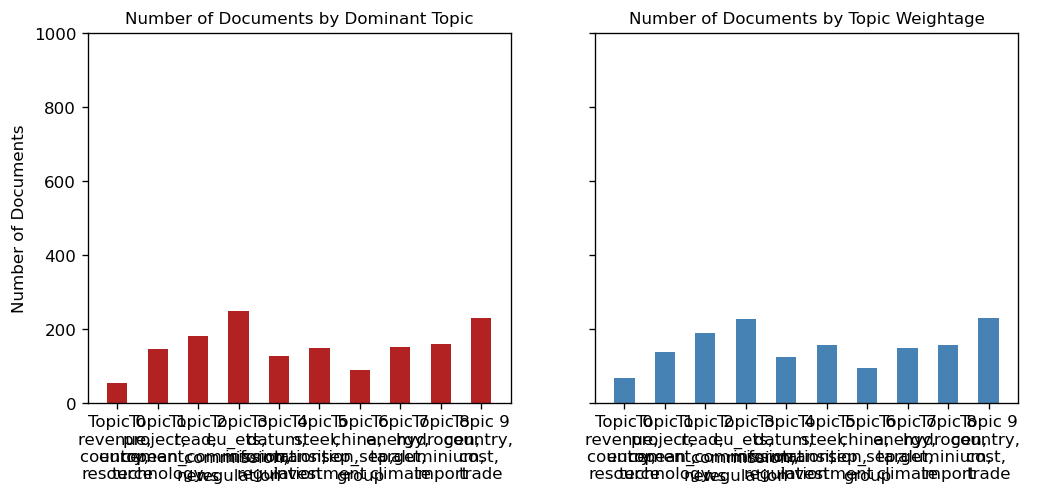

In [125]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

## 5.8 13. t-SNE Clustering Chart

In [127]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics))
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1463 samples in 0.016s...
[t-SNE] Computed neighbors for 1463 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1463
[t-SNE] Computed conditional probabilities for sample 1463 / 1463
[t-SNE] Mean sigma: 0.001107
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.023121
[t-SNE] KL divergence after 1000 iterations: 0.475009


Loading BokehJS ...